In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

<u> *RESPUESTAS* </u>
1. R: En este caso, para efectuar una limpieza mas precisa primero se mostrará la proporción de valores nulos por parametro con el 
objetivo de saber que variables nulas se podrian imputar o borrar sin modificar los resultados del analisis. Asi como tambien el tipo de variables que estan poseen.


In [2]:
df = pd.read_csv('../../data/machine_failure_data.csv')
df['Date'] = pd.to_datetime(df['Date'])



In [ ]:
null_table = pd.DataFrame({
    'Nulos': df.isnull().sum(),
    'Proporción (%)': round(df.isnull().sum() / len(df) * 100, 2),
    'Tipo': df.dtypes})
null_table = null_table[null_table['Nulos'] >= 0]
null_table.sort_values(by='Proporción (%)', ascending=False, inplace=True)
print(null_table)
unique_counts = df.nunique().sort_values()
print("################################################### \n VALORES UNICOS POR COLUMNA")
print(unique_counts)


                  Nulos  Proporción (%)            Tipo
Electricity       67816           47.69         float64
Evaporation       60843           42.79         float64
Parameter6_3pm    57094           40.15         float64
Parameter6_9am    53657           37.74         float64
Parameter5_9am    14014            9.86         float64
Parameter5_3pm    13981            9.83         float64
Parameter2_9am    10013            7.04          object
Parameter1_Dir     9330            6.56          object
Parameter1_Speed   9270            6.52         float64
Parameter2_3pm     3778            2.66          object
Parameter4_3pm     3610            2.54         float64
Parameter7_3pm     2726            1.92         float64
Parameter3_3pm     2630            1.85         float64
Parameter4_9am     1774            1.25         float64
Failure_today      1406            0.99          object
Leakage            1406            0.99         float64
Parameter3_9am     1348            0.95         

continuacion 1.R: En base a la informacion otorgada, se podrian imputar las variables Failure_today,Leakage,Min_Temp,Max_Temp ya que,
apenas cuentan con menos 1% de nulos.

con el objetivo de construir la matriz de correlación, se convertirá el parametro Failure_today en una variable binaria para poder utilizarla en la matriz de correlacion. Y asi estudiar que variables pueden explicar lo mismo y  eliminar una de estas para simplicifar el estudio.

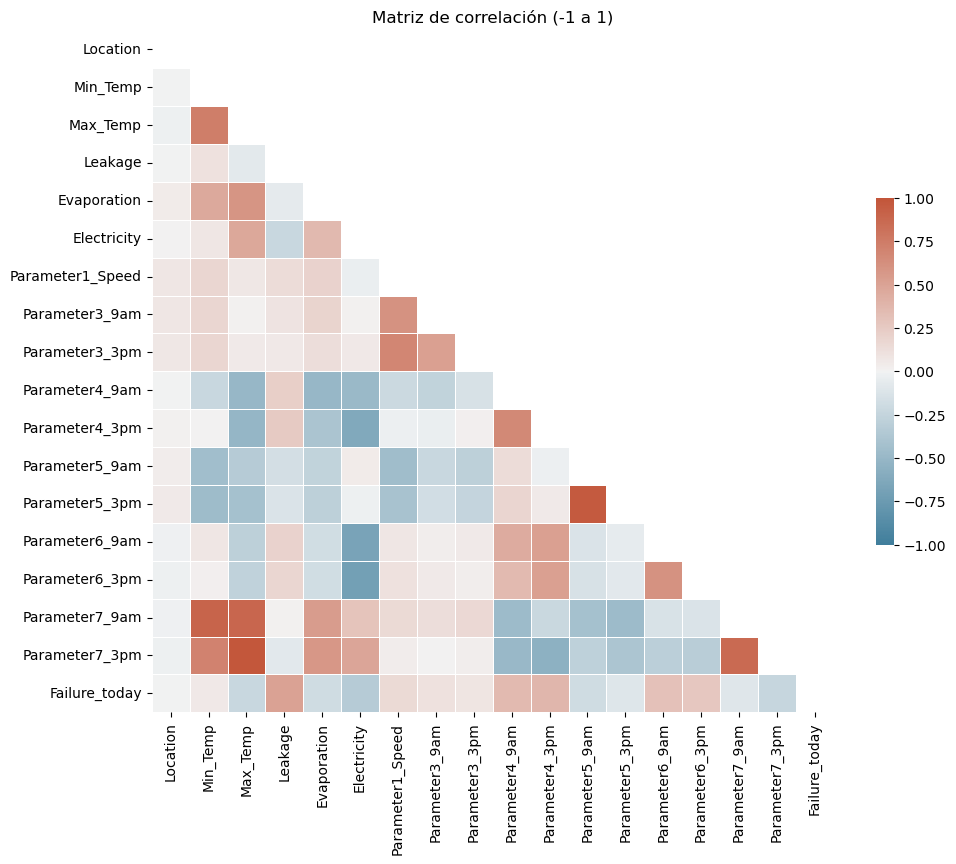

Top 20 correlaciones más fuertes:



,Variable 1,Variable 2,Correlación
52,Max_Temp,Parameter7_3pm,0.984562
210,Parameter5_9am,Parameter5_3pm,0.961348
33,Min_Temp,Parameter7_9am,0.901813
51,Max_Temp,Parameter7_9am,0.887020
286,Parameter7_9am,Parameter7_3pm,0.860574
20,Min_Temp,Max_Temp,0.736267
34,Min_Temp,Parameter7_3pm,0.708865
104,Electricity,Parameter6_3pm,-0.704202
116,Parameter1_Speed,Parameter3_3pm,0.686419
103,Electricity,Parameter6_9am,-0.675610



------------------------------------------------------------

Correlación con 'Failure_today':



,Variable,Correlación con Failure_today
0,Leakage,0.500997
1,Parameter4_3pm,0.378766
2,Parameter4_9am,0.353358
3,Parameter6_9am,0.305950
4,Parameter6_3pm,0.272149
5,Parameter1_Speed,0.155490
6,Parameter3_9am,0.102267
7,Parameter3_3pm,0.080074
8,Min_Temp,0.056185
9,Location,-0.004168


In [4]:
df['Failure_today'] = df['Failure_today'].map({'Yes': 1, 'No': 0})
df_numeric = df.select_dtypes(include='number')
corr = df_numeric.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Matriz de correlación (-1 a 1)")
plt.show()
corr_pairs = corr.unstack().reset_index()
corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']
corr_pairs = corr_pairs[corr_pairs['Variable 1'] != corr_pairs['Variable 2']]
corr_pairs['Key'] = corr_pairs.apply(lambda row: frozenset([row['Variable 1'], row['Variable 2']]), axis=1)
corr_pairs = corr_pairs.drop_duplicates(subset='Key').drop(columns='Key')
corr_pairs['|Correlación|'] = corr_pairs['Correlación'].abs()
top_corr = corr_pairs.sort_values(by='|Correlación|', ascending=False).head(20)
failure_corr = corr[['Failure_today']].drop('Failure_today').sort_values(by='Failure_today', ascending=False)
failure_corr = failure_corr.reset_index().rename(columns={'index': 'Variable', 'Failure_today': 'Correlación con Failure_today'})
print("Top 20 correlaciones más fuertes:\n")
display(top_corr[['Variable 1', 'Variable 2', 'Correlación']])
print("\n" + "-"*60 + "\n")
print("Correlación con 'Failure_today':\n")
display(failure_corr)

2.R: Una vez analizado los datos entregados, se elegirán las variables que mayor explican la probabilidad de un fallo en los sensores.

Se descartaran variables que posean un porcentaje muy alto de nulos aunque tengan alta relacion con failure_day. 

Asi como tambien solo se usarán variables que no tengan alta correlacion entre si. Siendo la eleccion tal que:

-Leakage (filtración): por cada unidad que aumente esta variable, aumenta la probabilidad de fallo en 1.98 puntos porcentuales.

-Parameter4_3pm: por cada unidad que aumente esta variable, aumenta la probabilidad de fallo en 0.43 puntos porcentuales.

-Parameter3_9am: por cada unidad que aumente esta variable, aumenta la probabilidad de fallo en 0.037 puntos porcentuales.

-Min_Temp (consumo eléctrico): por cada unidad que aumente esta variable, aumenta la probabilidad de fallo en 1.71 puntos porcentuales.

-Max_Temp (temperatura máxima): por cada unidad que aumente esta variable, disminuye la probabilidad de fallo en 1.72 puntos porcentuales.

In [5]:
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
vars_modelo = ['Leakage', 'Parameter4_9am', 'Parameter3_9am', 'Min_Temp', 'Max_Temp']

X1 = df[vars_modelo].copy()
imputer = SimpleImputer(strategy='mean') #El modelo no podia contener NaN, por ende, se imputo con la media a cada parametro elegido.
X1 = pd.DataFrame(imputer.fit_transform(X1), columns=vars_modelo)
X1 = sm.add_constant(X1)
y = df['Failure_today'].reset_index(drop=True)
X1 = X1.reset_index(drop=True)
mask = y.notna()
X1 = X1[mask]
y = y[mask]
model = sm.OLS(y, X1)
results = model.fit(cov_type='HC0')
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:          Failure_today   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     9505.
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:23:20   Log-Likelihood:                -45050.
No. Observations:              140787   AIC:                         9.011e+04
Df Residuals:                  140781   BIC:                         9.017e+04
Df Model:                           5                                         
Covariance Type:                  HC0                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0201      0.008      2.

3.R: Al correr el modelo probit, este  muestra que el parametro leakage es el mayor factor de fallo en los sensores.
Ademas, esto se valida con un  Pseudo R-squ.: 1.000.

Lo cual  puede significar que leakage interfiere con el modelo, no permitiendo generalizar y realizar prediccines.
El resto de parametros disminuyen la probabilidad de fallo aunque en una medida muy pequeña. 

Todos los parametros parecen tener un valor p cercano a 0 por ende, parecer ser significativos hasta el momento.

El análisis mostró que la variable Leakage predice casi perfectamente la ocurrencia de falla, resultando en separación perfecta. Por lo tanto, a partir de este punto será removida del modelo para evitar sobreajuste.

In [ ]:

#  modelo Probit 
model = sm.Probit(y, X1)
probit_model = model.fit(cov_type='HC0')
print(probit_model.summary())

# Efectos marginales promedio
mfxp = probit_model.get_margeff()
print(mfxp.summary())


         Current function value: 0.000000
         Iterations: 35
                          Probit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               140787
Model:                         Probit   Df Residuals:                   140781
Method:                           MLE   Df Model:                            5
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                   1.000
Time:                        21:23:23   Log-Likelihood:            -0.00031878
converged:                      False   LL-Null:                       -74787.
Covariance Type:                  HC0   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -97.4396      0.972   -100.229      0.000     -99.345     -95.534
Leakage           93.2252      0.894    104.257      

4.R: Gracias al cambio de remover la variable leakage, el modelo encontró una solución válida y ya no existe el problema de separacion.
Los valores p arrojan numeros cercanos a 0 por ende, todas las variables son altamente significativas.
Es estadísticamente válido, converge adecuadamente, y todos los parametros seleccionados muestran efectos robustos y coherentes con la lógica del proceso.

In [ ]:
# Redefinir las variables  SIN Leakage
vars_modelo = ['Parameter4_9am', 'Parameter3_9am', 'Min_Temp', 'Max_Temp']

X1 = df[vars_modelo].copy()
imputer = SimpleImputer(strategy='mean')
X1 = pd.DataFrame(imputer.fit_transform(X1), columns=vars_modelo)
X1 = sm.add_constant(X1)

y = df['Failure_today'].reset_index(drop=True)
X1 = X1.reset_index(drop=True)
mask = y.notna()
X1 = X1[mask]
y = y[mask]


In [8]:

logit_model = sm.Logit(y, X1).fit(cov_type='HC0')
print(logit_model.summary())
mfxl = logit_model.get_margeff()
print(mfxl.summary())
params = logit_model.params
conf = logit_model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
odds_ratios = np.exp(conf)
print("\n Odds Ratios:")
print(odds_ratios)


Optimization terminated successfully.
         Current function value: 0.394667
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               140787
Model:                          Logit   Df Residuals:                   140782
Method:                           MLE   Df Model:                            4
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.2570
Time:                        21:23:24   Log-Likelihood:                -55564.
converged:                       True   LL-Null:                       -74787.
Covariance Type:                  HC0   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.3158      0.074    -58.306      0.000      -4.461      -4.171
Parameter4_9am   

5.R: 
-Si bien los modelos OLS y Probit con la variable Leakage presentan buen ajuste estadístico, sólo el modelo Logit sin Leakage entrega resultados válidos y útiles para la predicción real de fallas, evitando problemas de sobreajuste y separación perfecta. 

Las variables Parameter4_9am, Parameter3_9am, Min_Temp y Max_Temp demostraron ser robustas y estadísticamente significativas en todas las especificaciones. 

Por lo tanto, el modelo Logit sin Leakage es el más adecuado para responder la pregunta de investigación y analizar los factores asociados a la probabilidad de falla.

6.R: un aumento en Parameter4_9am, Parameter3_9am y Max_Temp se asocia con un mayor número esperado de fallos en el mes, mientras que un aumento en Min_Temp se relaciona con una menor cantidad de fallos. 

Todos los coeficientes son estadísticamente significativos (p < 0.001), lo que indica que estos factores influyen de manera relevante en la frecuencia de fallas mensuales. 

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['YearMonth'] = df['Date'].dt.to_period('M').astype(str)
num_vars = df.select_dtypes(include='number').columns.tolist()
num_vars.remove('Failure_today')  
df_mensual = df.groupby('YearMonth')[num_vars].mean().reset_index()
fallos_mensuales = df.groupby('YearMonth')['Failure_today'].sum().reset_index()
fallos_mensuales.rename(columns={'Failure_today': 'Fail_Count'}, inplace=True)
df_mensual = df_mensual.merge(fallos_mensuales, on='YearMonth')
import pandas as pd
import matplotlib.pyplot as plt
df_mensual[['YearMonth', 'Fail_Count']].head()
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
vars_poisson = ['Parameter4_9am', 'Parameter3_9am', 'Min_Temp', 'Max_Temp']
df_model_poisson = df_mensual[vars_poisson].copy()
df_model_poisson = df_model_poisson.fillna(df_model_poisson.mean())
scaler = StandardScaler()
X_poisson_scaled = scaler.fit_transform(df_model_poisson)
X_poisson = pd.DataFrame(X_poisson_scaled, columns=vars_poisson)
X_poisson = sm.add_constant(X_poisson)
y_poisson = df_mensual['Fail_Count'].values
poisson_model = sm.GLM(y_poisson, X_poisson, family=sm.families.Poisson()).fit()
print(poisson_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  113
Model:                            GLM   Df Residuals:                      108
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2534.4
Date:                Thu, 24 Apr 2025   Deviance:                       4251.3
Time:                        21:23:25   Pearson chi2:                 3.01e+03
No. Iterations:                     4   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.5808      0.006    941.

7.R: Al existir un coeficiente de la regresión  positivo (0.0845) y  significativo (p < 0.001) podemos concluir que la diferencia positiva entre varianza y media es estadísticamente significativa por ende, existe sobre dispersion 

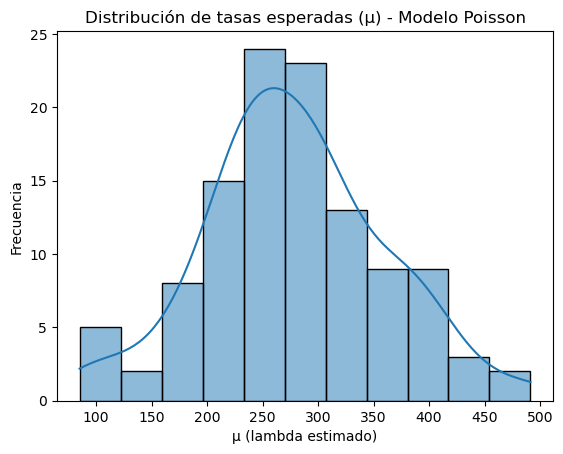

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.142
Model:                            OLS   Adj. R-squared (uncentered):              0.135
Method:                 Least Squares   F-statistic:                              18.59
Date:                Thu, 24 Apr 2025   Prob (F-statistic):                    3.50e-05
Time:                        21:23:25   Log-Likelihood:                         -623.23
No. Observations:                 113   AIC:                                      1248.
Df Residuals:                     112   BIC:                                      1251.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
# Añadir valores esperados del modelo Poisson al DataFrame mensual
df_mensual['plambda'] = poisson_model.mu
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data=df_mensual, x="plambda", kde=True)
plt.title("Distribución de tasas esperadas (μ) - Modelo Poisson")
plt.xlabel("μ (lambda estimado)")
plt.ylabel("Frecuencia")
plt.show()
# Sobredispersión auxiliar
aux = ((y_poisson - poisson_model.mu) ** 2 - poisson_model.mu) / poisson_model.mu
auxr = sm.OLS(aux, poisson_model.mu).fit()
print(auxr.summary())


8.R: Las variables Parameter4_9am y Parameter3_9am son los predictores más relevantes y robustos para explicar la frecuencia de fallas mensuales según el modelo binomial negativa, mientras que el efecto de las temperaturas mínimas y máximas no resultó significativo

In [ ]:
import statsmodels.api as sm


X_poisson.index = df_mensual.index
y_poisson = df_mensual['Fail_Count']

# Ajustar modelo Binomial Negativa
nb_model = sm.GLM(y_poisson, X_poisson, family=sm.families.NegativeBinomial()).fit()

print(nb_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:             Fail_Count   No. Observations:                  113
Model:                            GLM   Df Residuals:                      108
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -741.09
Date:                Thu, 24 Apr 2025   Deviance:                       35.911
Time:                        21:23:25   Pearson chi2:                     17.2
No. Iterations:                    14   Pseudo R-squ. (CS):             0.1348
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.5562      0.094     58.

9.R: 
el modelo Poisson no considera la sobredispersión presente en los datos, lo que puede llevar a una sobrestimación de la significancia de algunas variables. El modelo Binomial Negativa, al corregir este problema, entrega estimaciones y significancias más realistas, por ende, el modelo Binomial Negativa es el más adecuado para la investigacion, ya que ajusta correctamente la variabilidad extra observada en los datos mensuales de fallas.

Parameter4_9am y Parameter3_9am resultaron ser las variables más robustas a la especificación, mostrando efectos positivos y significativos en ambos modelos.
